In [1]:
import os
#if not os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#    raise 'stop'
if not os.path.isdir('d:/flagellar/'):
    deps_path = '/kaggle/usr/lib/flg-packages/'
    !pip install --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt
    !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics
    !rm -rf ./packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import flg_yolo
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

fast_mode = False
if fls.is_submission:
    fast_mode = False

In [3]:
all_data = fls.load_all_train_data()

In [4]:
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
test_data = test_data
if fast_mode:
    train_data = train_data[1:5]
    test_data = test_data[2:4]
len(train_data), len(test_data)

(444, 200)

In [12]:
def run_for_model(model_name, is_yolo):
    model = fls.dill_load(fls.model_dir+ model_name)
    if is_yolo:
        model.fix_norm_bug = True
    model.run_in_parallel=True
    for use_extra in [True]:
        if use_extra:
            test_data_here = fls.load_all_extra_data(for_yolo = is_yolo)
        else:
            test_data_here = test_data
        test_data_here = test_data_here
        inferred_test_data = model.infer(test_data_here)
        print(len(test_data_here), fls.score_competition_metric(inferred_test_data, test_data_here))

In [13]:
#importlib.reload(flg_yolo)
#importlib.reload(fls)
run_for_model("yolo.pickle",True)
#run_for_model("unet_normbugfixed.pickle",False)
# REMEMBER: UNET has advantage (gets smaller part of data)
# 410 0.40616 (norm bug fixed: 0.354)
# 200 0.828
# 410 0.447
# 200 0.817

410 0.35410764872521244


In [7]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [8]:
fls.dill_save('d:/temp/temp.pickle', test_data[0])

In [9]:
test_data[0]

DataKaggle(is_train=True, name='tomo_ff505c', labels=     z    y    x
0  111  816  678, labels_unfiltered=Empty DataFrame
Columns: []
Index: [], loaded_state='unloaded', data=None, data_shape=(300, 959, 928), voxel_spacing=15.6, mean_per_slice=array([], dtype=float64), std_per_slice=array([], dtype=float64), percentiles_per_slice=array([], shape=(8, 0), dtype=float64), resize_factor=1.0, target_size=None)

In [10]:
test_data_here = fls.load_all_extra_data()

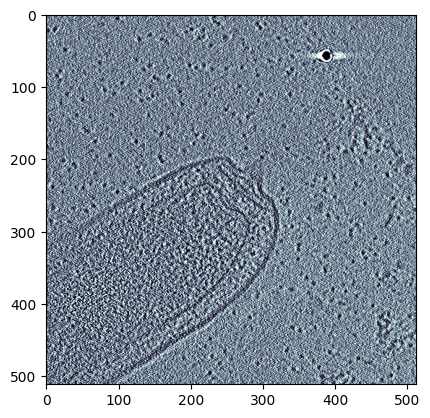

In [11]:
d=test_data_here[0]
d.load_to_memory()
plt.figure()
plt.imshow(d.data[d.labels['z'][0], :,:], cmap='bone')